In [17]:
import subprocess
import os
import sys

import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [18]:
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'

In [19]:
data_path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'

h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
for k in ['exampledataset', 'NormanWeissman2019_raw']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['PapalexiSatija2021_eccite_arrayed_protein', 'PapalexiSatija2021_eccite_protein', 'FrangiehIzar2021_protein']:
    if k in h5_files.keys(): del h5_files[k]
for k in ['gene_scores', 'ChromVar', 'LSI_embedding', 'markerpeak_target', 'peak_bc']:
    if k in h5_files.keys(): del h5_files[k]

print(len(h5_files))
list(h5_files.keys())

35


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ChangYe2021',
 'GehringPachter2019',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissman2016_GSM2406675_10X001',
 'SrivatsanTrapnell2020_sciplex2

# Statistics

In [5]:
# get distances
key = 'NormanWeissman2019_filtered'
if False:
    pwd = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_pca_distances_{key}_tables.csv', index_col=0)
    pwd_mean = pd.read_csv(f'/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/pairwise_mean_pca_distances_{key}_tables.csv', index_col=0)
else:
    SDIR = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
    table_path = '/fast/work/users/peidlis_c/projects/perturbation_resource_paper/single_cell_perturbation_data/code/notebooks/data_analysis/analysis_screens/tables/'
    adata = sc.read(SDIR+'tmp_data_' + key + '.h5')        
    pwd = pairwise_pca_distances(adata, 'perturbation', obsm_key='X_pca')
    pwd_mean = pairwise_mean_pca_distances(adata, 'perturbation', obsm_key='X_pca')

100%|██████████| 237/237 [02:11<00:00,  1.81it/s]


In [6]:
# derive basic statistics
sigmas = np.diag(pwd)
std = np.sqrt(sigmas/2)
deltas = pwd.loc[:, 'control']
deltas_ = np.sqrt(deltas/2)
deltas_mean = pwd_mean.loc[:, 'control']

# aggregate
perturbations = pwd.index
df = pd.DataFrame([sigmas, std, deltas, deltas_, deltas_mean], index=['sigma', 'std', 'delta', 'delta_', 'delta_mean'], columns=perturbations).T
df.index.name = 'perturbation'
df['dataset'] = key

# normalized statistics (divide by spread of the unperturbed cells)
df['dps'] = df['delta'] / df.loc['control', 'std']
df['dps_'] = df['delta_'] / df.loc['control', 'std']
df['sps'] = df['sigma'] / df.loc['control', 'std']
df['stdpstd'] = df['std'] / df.loc['control', 'std']
df['dmps'] = df['delta_mean'] / df.loc['control', 'std']

df = df.sort_values('dps')

In [7]:
N = 7
top = list(df.index[-N:])
bot = list(df.index[:N])
df['delta_group'] = 'Nothing'
df['delta_group'][df.index.isin(top)] = 'High delta'
df['delta_group'][df.index.isin(bot)] = 'Low delta'
df['delta_group'][df.index=='control'] = 'control'

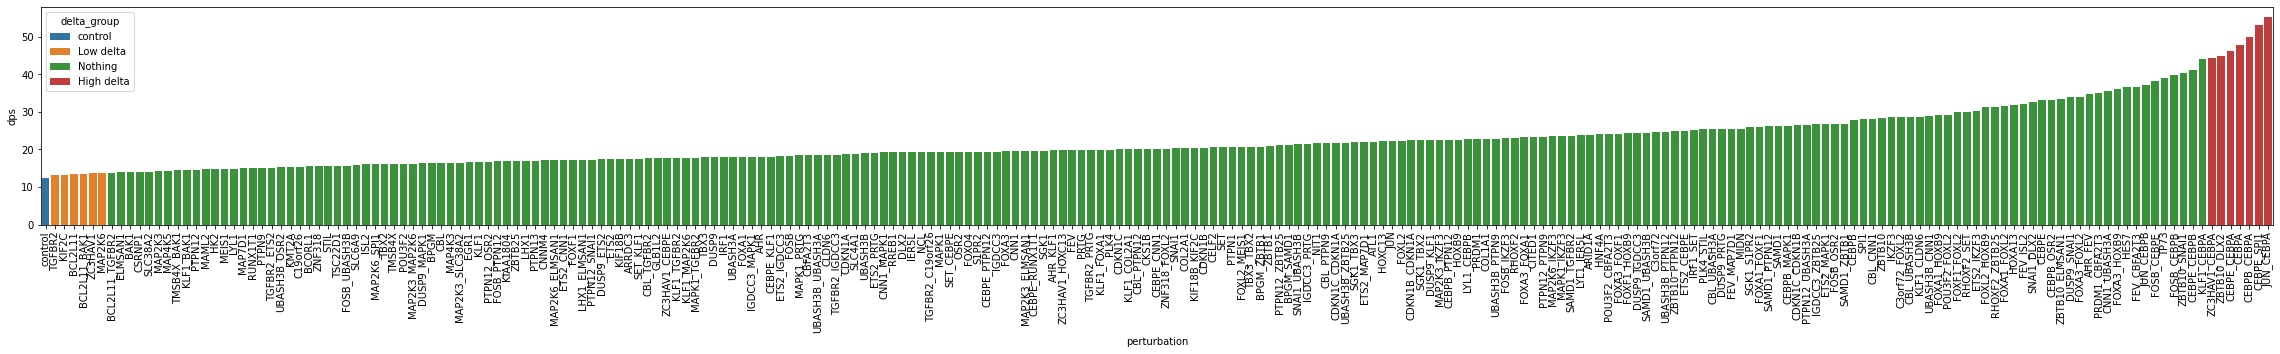

In [10]:
fig, ax = pl.subplots(figsize=[40,4])
sns.barplot(data=df.reset_index(), x='perturbation', y='dps', hue='delta_group', dodge=False, order=df.index)
pl.xticks(rotation=90)
pl.show()

# Single cell Embeddings

In [160]:
adata = sc.read(f"/fast/scratch/users/peidlis_c/perturbation_resource_paper/tmp_data_{key}.h5")

In [162]:
# 11 sec for NormanWeissman
sc.tl.umap(adata)

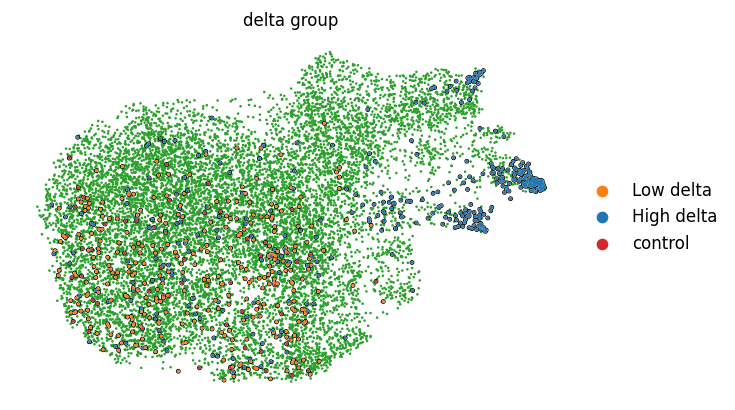

In [225]:
adata.obs['delta_group'] = 'Nothing'
adata.obs['delta_group'][adata.obs.perturbation.isin(top)] = 'High delta'
adata.obs['delta_group'][adata.obs.perturbation.isin(bot)] = 'Low delta'
adata.obs['delta_group'][adata.obs.perturbation=='control'] = 'control'
scv.pl.scatter(adata, color='delta_group', show=True, dpi=120, legend_loc='right margin', add_outline=['Low delta', 'High delta', 'control'])

In [226]:
subdata = adata[np.isin(adata.obs.perturbation, ['control']+ top + bot)].copy()
sc.pp.highly_variable_genes(subdata)
sc.pp.pca(subdata)
sc.pp.neighbors(subdata, n_neighbors=5)
sc.tl.umap(subdata)
del subdata.uns['perturbation_colors']

import pymde
mde = pymde.preserve_neighbors(subdata.obsm['X_pca'], verbose=False)
embedding = mde.embed(verbose=False)
subdata.obsm['X_pymde_pe'] = np.array(embedding)
mde = pymde.preserve_distances(subdata.obsm['X_pca'], verbose=False)
embedding = mde.embed(verbose=False)
subdata.obsm['X_pymde_pd'] = np.array(embedding)

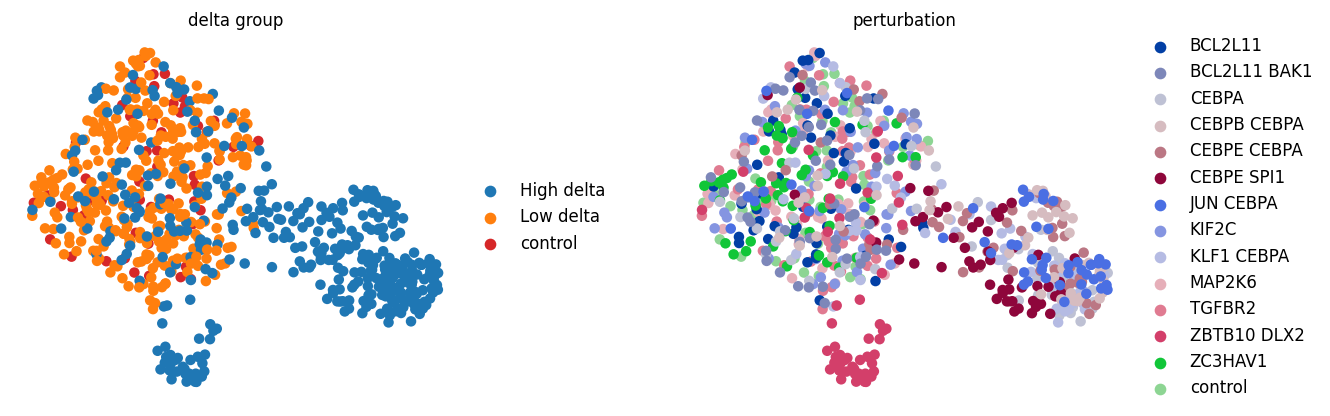

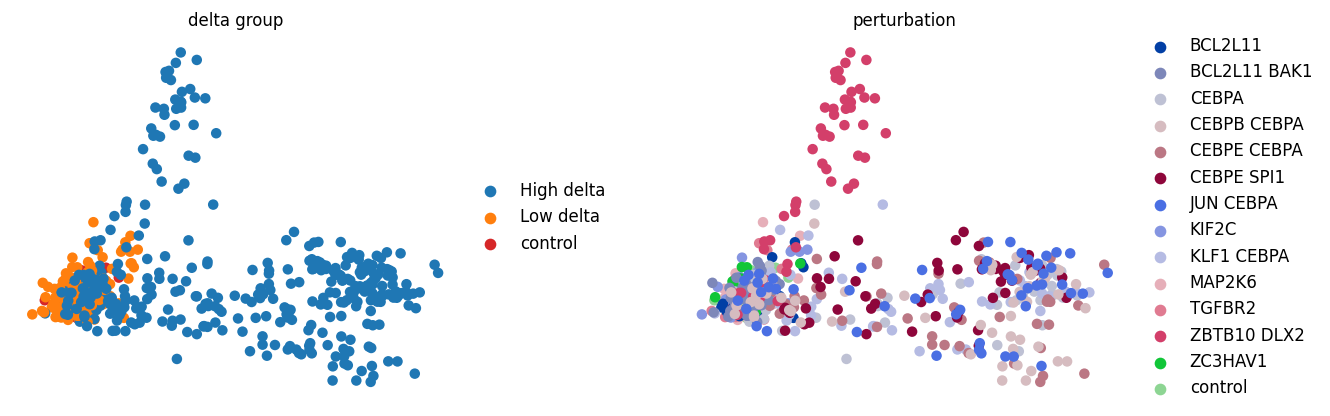

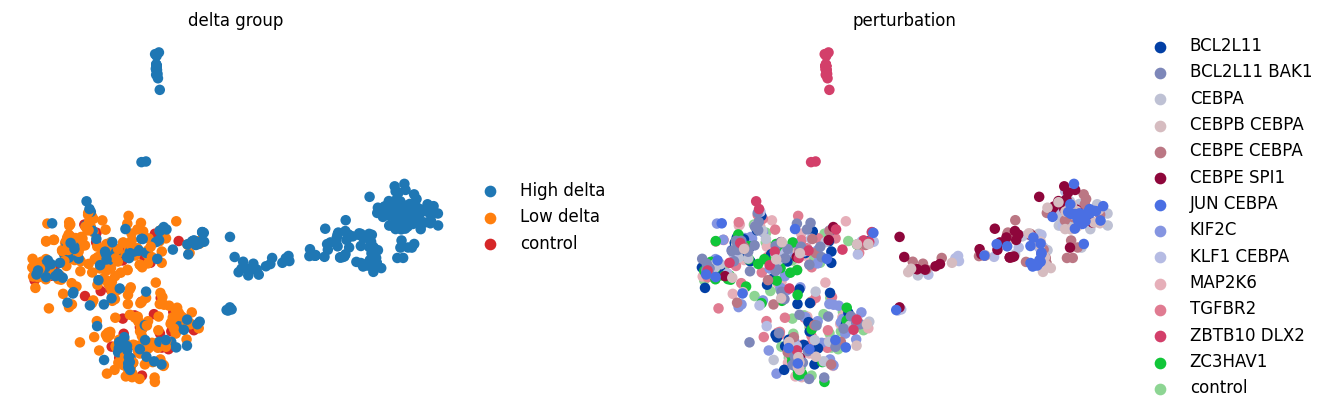

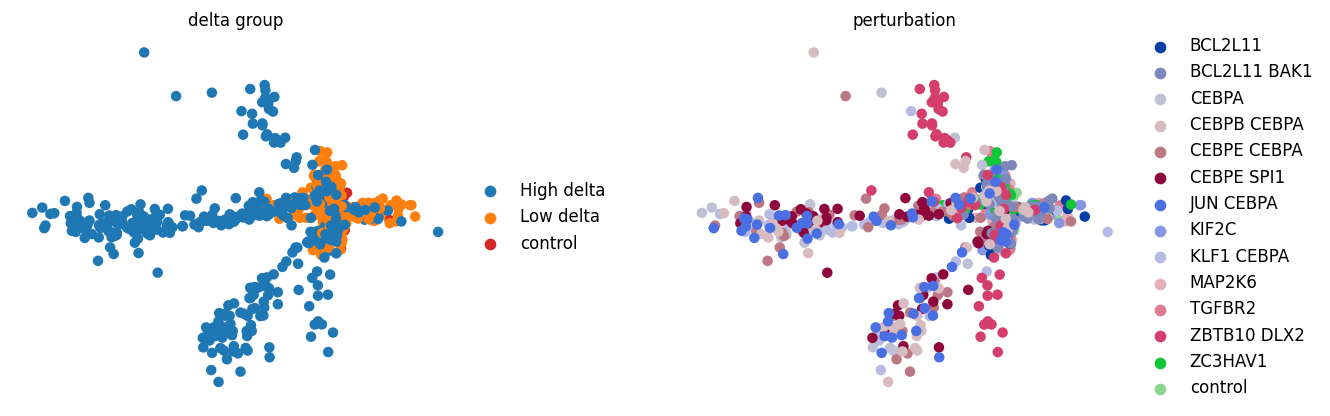

In [227]:
scv.pl.scatter(subdata, color=['delta_group', 'perturbation'], show=True, dpi=120, legend_loc='right margin', wspace=0.5)
scv.pl.scatter(subdata, basis='pca', color=['delta_group', 'perturbation'], show=True, dpi=120, legend_loc='right margin', wspace=0.5)
scv.pl.scatter(subdata, basis='pymde_pe', color=['delta_group', 'perturbation'], show=True, dpi=120, legend_loc='right margin', wspace=0.5)
scv.pl.scatter(subdata, basis='pymde_pd', color=['delta_group', 'perturbation'], show=True, dpi=120, legend_loc='right margin', wspace=0.5)

# Pseudobulk Embeddings

In [228]:
pdata = pseudo_bulk(adata, ['perturbation'])
sc.pp.normalize_per_cell(pdata)
sc.pp.log1p(pdata)

sc.pp.pca(pdata)
sc.pp.neighbors(pdata, n_neighbors=5)
sc.tl.umap(pdata)

pdata.obs['perturbation'] = pdata.obs['perturbation'].astype('category')
pdata.obs['delta_group'] = 'control'
pdata.obs['delta_group'][pdata.obs.perturbation.isin(top)] = 'High delta'
pdata.obs['delta_group'][pdata.obs.perturbation.isin(bot)] = 'Low delta'

In [16]:
pdata = pseudo_bulk(adata, ['perturbation'])

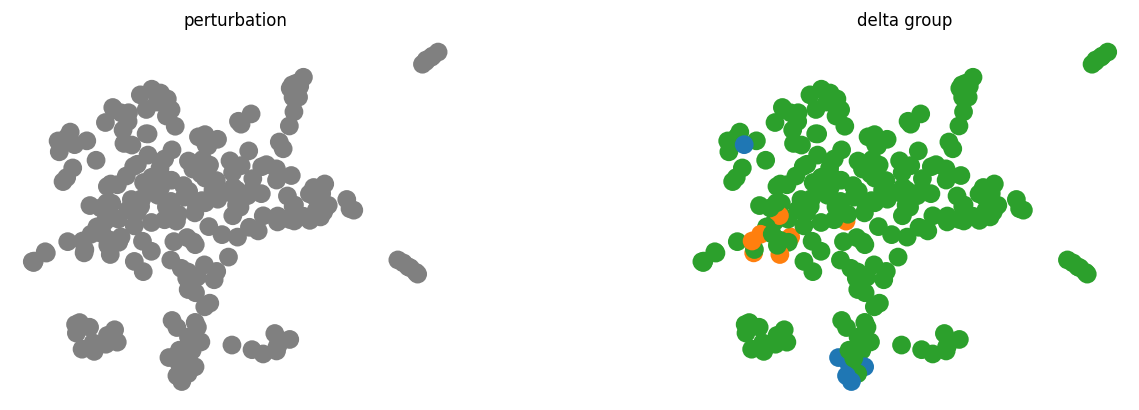

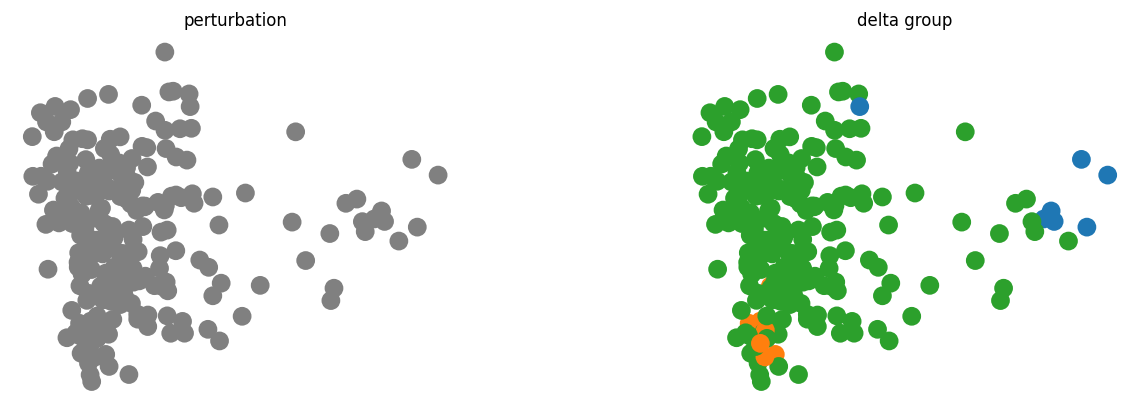

In [229]:
scv.pl.scatter(pdata, color=['perturbation', 'delta_group'], show=True, dpi=120, legend_loc=False, wspace=0.5)
scv.pl.scatter(pdata, basis='pca', color=['perturbation', 'delta_group'], show=True, dpi=120, legend_loc=False, wspace=0.5)

# Evaluation

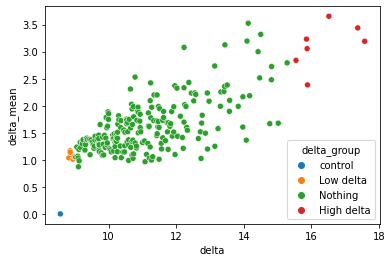

In [238]:
# without squares
sns.scatterplot(data=df, x='delta', y='delta_mean', hue='delta_group');

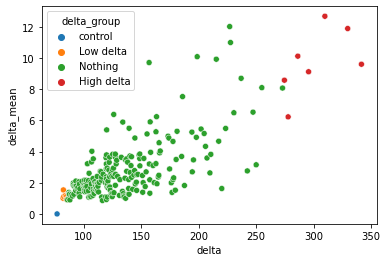

In [11]:
sns.scatterplot(data=df, x='delta', y='delta_mean', hue='delta_group');

Observations:
- There are perturbations that have different deltas in pseudobulk, but they largely correlate
- Normalizing delta by std is not working. I think I'll have to do /2 and sqrt

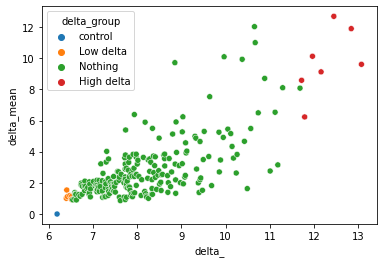

In [12]:
# delta_ of control should be 1, there is something off
# still nice that the scales are now similar
sns.scatterplot(data=df, x='delta_', y='delta_mean', hue='delta_group');